In [1]:
%matplotlib inline
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
import sqlite3
from main_db_script import db_filename
from hr_db_scripts.main_db_script import get_table_for_variable_code, get_db_table_as_df

In [2]:
def round_down_near_24(datetimes): # round down the times near midnight so the tide levels stay on the correct day
    close_time_idx = datetimes.indexer_between_time('23:29', '23:59')
    adjusted_times = datetimes[close_time_idx] - pd.Timedelta(minutes=15)
    dt = pd.Series(datetimes)
    dt[close_time_idx] = adjusted_times
    dt = pd.DatetimeIndex(dt)
    return dt

In [3]:
def cln_n_rnd_times(df):
    for i in range(df.shape[1]):
        datetimes = df.iloc[:, i]
        times = pd.DatetimeIndex(datetimes)
        rnd_dn = round_down_near_24(times)
        df.iloc[:, i] = rnd_dn
    return df

In [4]:
def pivot_dv_df(df):
    return df.pivot(columns='SiteID', values='Value')

In [5]:
def rename_cols(df, var_abbrev):
    if var_abbrev != "":
        new_df = df.copy()
        cols = df.columns.tolist()
        new_cols = ['{}-{}'.format(var_abbrev, c) for c in cols]
        new_df.columns = new_cols
        return new_df
    else:
        return df

In [6]:
def filter_max_rain_time_dfs(rain_daily_df, time_df):
    timemx_filt = pd.DataFrame(np.where(rain_daily_df>0, time_df, np.datetime64('NaT')))
    timemx_filt.columns = time_df.columns
    timemx_filt.index = time_df.index
    return timemx_filt

In [7]:
def tide_when_rain_max(rn_mx_time_df):
    td_df = get_table_for_variable_code('six_min_tide')
    try:
        td_df = pivot_dv_df(td_df)
    except:
        td_df = remove_duplicates(td_df)
        td_df = pivot_dv_df(td_df)
    td_df = td_df.resample('15T').mean()
    rn_mx_time_rnd = cln_n_rnd_times(rn_mx_time_df)
    l = []
    for c in rn_mx_time_rnd.columns:
        times = rn_mx_time_rnd.loc[:, c]
        tides = td_df.loc[times].resample('D').max()
        rain_var = c.split('_')[0]
        rain_site = c.split('-')[-1]
        new_cols = ['{}-{}_td-{}'.format(rain_var, rain_site, col) for col in tides.columns]
        tides.columns = new_cols
        l.append(tides)
    new_df = pd.concat(l, axis=1)
    new_df.sort_index(inplace=True)
    return new_df

In [8]:
def remove_duplicates(df):
    siteids = df['SiteID'].unique()
    df.reset_index(inplace=True)
    print df.shape
    non_duplicated = list()
    for site in siteids:
        df_site = df[df['SiteID'] == site]
        df_site_vals = df_site['Datetime']
        df_no_dups = ~df_site_vals.duplicated()
        df_no_dups_idx = df_site[df_no_dups].index
        non_duplicated.extend(df_no_dups_idx.tolist())
    df = df.loc[non_duplicated]
    df.set_index('Datetime', drop=True, inplace=True)
    print df.shape
    return df

In [9]:
def daily_pivot_table(var_code, agg_function, abbreviation):    
    df = get_table_for_variable_code(var_code)
    try:
        dfp = pivot_dv_df(df)
    except ValueError:
        df = remove_duplicates(df)
        dfp = pivot_dv_df(df)
    dfd = dfp.resample('D')
    aggrd = dfd.agg(agg_function)
    rnmed = rename_cols(aggrd, abbreviation)
    return rnmed

In [10]:
sites = get_db_table_as_df('sites')

#  Rainfall

In [11]:
# get rainfall data at 15 min interval
rain_df = get_table_for_variable_code('rainfall')

## Daily Rainfall

In [12]:
rain_daily15 = daily_pivot_table('rainfall', np.sum, '')
rain_daily = daily_pivot_table('daily_rainfall', np.sum, '')
rain_daily_comb_no_name = pd.concat([rain_daily, rain_daily15], axis=1)
rain_daily_comb_named = rename_cols(rain_daily_comb_no_name, 'rd')
rain_daily_comb_named.head()

,rd-19,rd-20,rd-1,rd-2,rd-7,rd-11,rd-12,rd-13,rd-14,rd-15,rd-16,rd-21
Datetime,,,,,,,,,,,,
2010-01-01,0.01,0.01,NaN,NaN,0.05,0.03,0.06,0.02,0.01,0.01,0.02,0.03
2010-01-02,0.00,0.00,NaN,NaN,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
2010-01-03,0.00,0.00,NaN,NaN,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00
2010-01-04,0.00,0.00,NaN,NaN,0.10,0.10,0.00,0.11,0.00,0.00,0.00,0.00
2010-01-05,0.00,0.00,NaN,NaN,0.00,0.00,0.00,0.00,0.12,0.00,0.00,0.11


## Hourly Rainfall

In [13]:
rain15 = pivot_dv_df(rain_df)
rain_hourly_totals = rain15.rolling(window='H').sum()
rhr_mx = rain_hourly_totals.resample('D').max()
rhr_mx = rename_cols(rhr_mx, 'rhrmx')
rhr_mx.head()

,rhrmx-1,rhrmx-2,rhrmx-7,rhrmx-11,rhrmx-12,rhrmx-13,rhrmx-14,rhrmx-15,rhrmx-16,rhrmx-21
Datetime,,,,,,,,,,
2010-01-01,NaN,NaN,0.04,0.01,0.04,0.01,0.01,0.01,0.01,0.02
2010-01-02,NaN,NaN,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
2010-01-03,NaN,NaN,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00
2010-01-04,NaN,NaN,0.10,0.10,0.00,0.11,0.00,0.00,0.00,0.00
2010-01-05,NaN,NaN,0.00,0.00,0.00,0.00,0.12,0.00,0.00,0.11


In [14]:
rhr_timemx = rain_hourly_totals.groupby(pd.TimeGrouper('D')).idxmax()
rhr_timemx = rename_cols(rhr_timemx, 'rhr_mxtime')
rhr_timemx = filter_max_rain_time_dfs(rain_daily15, rhr_timemx)
rhr_timemx.head()

,rhr_mxtime-1,rhr_mxtime-2,rhr_mxtime-7,rhr_mxtime-11,rhr_mxtime-12,rhr_mxtime-13,rhr_mxtime-14,rhr_mxtime-15,rhr_mxtime-16,rhr_mxtime-21
Datetime,,,,,,,,,,
2010-01-01,NaT,NaT,2010-01-01 22:45:00,2010-01-01 00:15:00,2010-01-01 23:00:00,2010-01-01 00:45:00,2010-01-01 00:15:00,2010-01-01 05:00:00,2010-01-01 00:45:00,2010-01-01 23:00:00
2010-01-02,NaT,NaT,NaT,2010-01-02 13:15:00,NaT,NaT,NaT,NaT,NaT,NaT
2010-01-03,NaT,NaT,NaT,NaT,NaT,2010-01-03 07:00:00,NaT,NaT,NaT,NaT
2010-01-04,NaT,NaT,2010-01-04 13:30:00,2010-01-04 13:00:00,NaT,2010-01-04 12:45:00,NaT,NaT,NaT,NaT
2010-01-05,NaT,NaT,NaT,NaT,NaT,NaT,2010-01-05 10:15:00,NaT,NaT,2010-01-05 10:30:00


## 15-min max rainfall

In [15]:
r15_mx = rain15.resample('D').max()
r15_mx = rename_cols(r15_mx, 'r15mx')
r15_mx.head()

,r15mx-1,r15mx-2,r15mx-7,r15mx-11,r15mx-12,r15mx-13,r15mx-14,r15mx-15,r15mx-16,r15mx-21
Datetime,,,,,,,,,,
2010-01-01,NaN,NaN,0.02,0.01,0.02,0.01,0.01,0.01,0.01,0.02
2010-01-02,NaN,NaN,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
2010-01-03,NaN,NaN,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00
2010-01-04,NaN,NaN,0.10,0.10,0.00,0.11,0.00,0.00,0.00,0.00
2010-01-05,NaN,NaN,0.00,0.00,0.00,0.00,0.12,0.00,0.00,0.11


In [16]:
r15_timemx = rain15.groupby(pd.TimeGrouper('D')).idxmax()
r15_timemx = rename_cols(r15_timemx, 'r15_mxtime')
r15_timemx = filter_max_rain_time_dfs(rain_daily15, r15_timemx)
r15_timemx.head()

,r15_mxtime-1,r15_mxtime-2,r15_mxtime-7,r15_mxtime-11,r15_mxtime-12,r15_mxtime-13,r15_mxtime-14,r15_mxtime-15,r15_mxtime-16,r15_mxtime-21
Datetime,,,,,,,,,,
2010-01-01,NaT,NaT,2010-01-01 22:30:00,2010-01-01 00:15:00,2010-01-01 22:45:00,2010-01-01 00:45:00,2010-01-01 00:15:00,2010-01-01 05:00:00,2010-01-01 00:45:00,2010-01-01 23:00:00
2010-01-02,NaT,NaT,NaT,2010-01-02 13:15:00,NaT,NaT,NaT,NaT,NaT,NaT
2010-01-03,NaT,NaT,NaT,NaT,NaT,2010-01-03 07:00:00,NaT,NaT,NaT,NaT
2010-01-04,NaT,NaT,2010-01-04 13:30:00,2010-01-04 13:00:00,NaT,2010-01-04 12:45:00,NaT,NaT,NaT,NaT
2010-01-05,NaT,NaT,NaT,NaT,NaT,NaT,2010-01-05 10:15:00,NaT,NaT,2010-01-05 10:30:00


### Rain prev 3 days

In [17]:
rain_prev_3_days = rain_daily_comb_no_name.shift(1).rolling(window=3).sum()
rain_prev_3_days = rename_cols(rain_prev_3_days, 'r3d')
rain_prev_3_days.head()

,r3d-19,r3d-20,r3d-1,r3d-2,r3d-7,r3d-11,r3d-12,r3d-13,r3d-14,r3d-15,r3d-16,r3d-21
Datetime,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,0.01,0.01,NaN,NaN,0.05,0.04,0.06,0.04,0.01,0.01,0.02,0.03
2010-01-05,0.00,0.00,NaN,NaN,0.10,0.11,0.00,0.13,0.00,0.00,0.00,0.00


In [18]:
rain_daily_comb_named['rd-14'][rain_daily_comb_named['rd-14']<0]

Series([], Freq: D, Name: rd-14, dtype: float64)

In [19]:
rain15.loc['2014-06-24']

SiteID,1,2,7,11,12,13,14,15,16,21
Datetime,,,,,,,,,,
2014-06-24 00:00:00,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-06-24 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2014-06-24 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2014-06-24 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2014-06-24 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2014-06-24 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2014-06-24 00:06:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2014-06-24 00:07:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2014-06-24 00:08:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


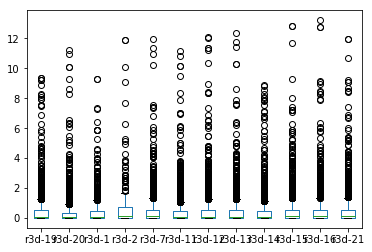

In [20]:
rain_prev_3_days.plot.box()

#  Groundwater

In [21]:
gw_df = daily_pivot_table('shallow_well_depth', np.mean, 'gw_av')
gw_df.head()

,gw_av-4,gw_av-5,gw_av-6,gw_av-8,gw_av-9,gw_av-10,gw_av-11
Datetime,,,,,,,
2010-01-01,0.181510,3.924140,NaN,6.050129,2.858511,3.167374,3.509806
2010-01-02,0.051690,3.548121,NaN,5.990354,2.745979,3.238457,3.637924
2010-01-03,-0.075826,3.103997,NaN,5.910525,2.650683,3.127058,3.511233
2010-01-04,-0.186996,2.882649,NaN,5.770411,2.579872,2.990989,3.348661
2010-01-05,-0.251922,2.772379,NaN,5.648158,2.538736,2.873044,3.232544


#  Tide

## Average daily tide

In [22]:
tide_df = daily_pivot_table('six_min_tide', np.mean, 'td_av')
tide_df.head()

(1290376, 6)
(1288206, 5)


,td_av-17,td_av-18
Datetime,,
2010-01-01,0.675800,0.679987
2010-01-02,0.604608,0.707200
2010-01-03,-0.608692,-0.579467
2010-01-04,-0.515733,-0.522700
2010-01-05,0.020037,0.017379


##  Tide when rain is at max

In [23]:
td_r15mx = tide_when_rain_max(r15_timemx)
td_r15mx.head()

(1290376, 6)
(1288206, 5)


,r15-1_td-17,r15-1_td-18,r15-2_td-17,r15-2_td-18,r15-7_td-17,r15-7_td-18,r15-11_td-17,r15-11_td-18,r15-12_td-17,r15-12_td-18,r15-13_td-17,r15-13_td-18,r15-14_td-17,r15-14_td-18,r15-15_td-17,r15-15_td-18,r15-16_td-17,r15-16_td-18,r15-21_td-17,r15-21_td-18
Datetime,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,1.814333,2.148,-0.246,-0.092,1.8375,2.0505,-0.567500,-0.503500,-0.2460,-0.092,-0.049333,-0.431,-0.5675,-0.5035,1.836333,1.962000
2010-01-02,NaN,NaN,NaN,NaN,NaN,NaN,0.912,1.273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.869333,-1.160333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,NaN,NaN,NaN,NaN,0.729333,0.919,0.901,1.135,NaN,NaN,0.968000,1.240500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6005,0.530,NaN,NaN,NaN,NaN,0.772000,0.740333


In [24]:
td_rhrmx = tide_when_rain_max(rhr_timemx)
td_rhrmx.head()

(1290376, 6)
(1288206, 5)


,rhr-1_td-17,rhr-1_td-18,rhr-2_td-17,rhr-2_td-18,rhr-7_td-17,rhr-7_td-18,rhr-11_td-17,rhr-11_td-18,rhr-12_td-17,rhr-12_td-18,rhr-13_td-17,rhr-13_td-18,rhr-14_td-17,rhr-14_td-18,rhr-15_td-17,rhr-15_td-18,rhr-16_td-17,rhr-16_td-18,rhr-21_td-17,rhr-21_td-18
Datetime,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,1.837500,2.0505,-0.246,-0.092,1.836333,1.962,-0.567500,-0.503500,-0.2460,-0.092,-0.049333,-0.431,-0.5675,-0.5035,1.836333,1.962000
2010-01-02,NaN,NaN,NaN,NaN,NaN,NaN,0.912,1.273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.869333,-1.160333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,NaN,NaN,NaN,NaN,0.729333,0.9190,0.901,1.135,NaN,NaN,0.968000,1.240500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6005,0.530,NaN,NaN,NaN,NaN,0.772000,0.740333


## HI/LOs

In [25]:
hilos = []
for v in ['high_tide', 'high_high_tide', 'low_tide', 'low_low_tide']:
    hilos.append(daily_pivot_table(v, np.mean, "".join(w[0] for w in v.split('_'))))

In [26]:
hilo_df = pd.concat(hilos, axis=1)
hilo_df.head()

,ht-17,ht-18,hht-17,hht-18,lt-17,lt-18,llt-17,llt-18
Datetime,,,,,,,,
2010-01-01,1.952,2.241,2.493,2.7490,-0.797,-1.043,-1.198,-1.430
2010-01-02,NaN,NaN,1.939,2.2395,-0.604,-0.840,-1.056,-1.132
2010-01-03,0.830,1.096,NaN,NaN,-1.841,-2.024,-2.516,-2.694
2010-01-04,NaN,NaN,1.102,1.3190,-1.693,-1.949,-2.349,-2.566
2010-01-05,1.355,1.654,1.480,1.7680,-1.253,-1.453,-1.306,-1.522


#  Wind

In [27]:
wind_dfs = []
for v in ['WDF2', 'WSF2', 'AWDR', 'AWND', 'WGF6', 'WSF6', 'WDF6', 'WS2min', 'WD2min']:
    if v == 'WSF6':
        abbr = 'AWND'
    elif v == 'WDF6':
        abbr = 'AWDR'
    elif v == 'WS2min':
        abbr = 'AWND'
    elif v == 'WD2min':
        abbr = 'AWDR'
    else:
        abbr = v
    wind_dfs.append(daily_pivot_table(v, np.mean, abbr))
all_wind = pd.concat(wind_dfs, axis=1)
all_wind.head()

,WDF2-19,WDF2-20,WSF2-19,WSF2-20,AWDR-19,AWND-19,AWND-20,WGF6-18,AWND-18,AWDR-18,AWND-3,AWDR-3
Datetime,,,,,,,,,,,,
2010-01-01,360.0,340.0,23.0,23.9,353.0,6.3,7.2,6.798833,4.384917,201.898458,NaN,NaN
2010-01-02,340.0,310.0,23.9,30.0,321.0,13.9,19.9,18.064142,11.356569,337.813724,NaN,NaN
2010-01-03,290.0,290.0,17.9,28.0,295.0,11.2,16.6,16.935208,10.734083,325.094250,NaN,NaN
2010-01-04,330.0,310.0,16.1,21.0,306.0,7.2,9.8,9.317000,6.280500,324.969875,NaN,NaN
2010-01-05,310.0,300.0,15.0,17.0,292.0,6.0,8.5,8.925750,6.063000,317.637125,NaN,NaN


In [28]:
feature_df = pd.concat([all_wind, hilo_df, td_r15mx, td_rhrmx, tide_df, gw_df, r15_mx, rhr_mx, rain_daily_comb_named, rain_prev_3_days], axis=1)
feature_df = feature_df.loc['2010-09-15':'2016-10-15']
feature_df.head()

,WDF2-19,WDF2-20,WSF2-19,WSF2-20,AWDR-19,AWND-19,AWND-20,WGF6-18,AWND-18,AWDR-18,...,r3d-1,r3d-2,r3d-7,r3d-11,r3d-12,r3d-13,r3d-14,r3d-15,r3d-16,r3d-21
Datetime,,,,,,,,,,,,,,,,,,,,,
2010-09-15,140.0,110.0,13.0,15.0,119.0,5.1,5.6,NaN,NaN,NaN,...,NaN,NaN,2.200000e-01,2.400000e-01,2.600000e-01,2.200000e-01,3.100000e-01,2.400000e-01,3.600000e-01,2.400000e-01
2010-09-16,220.0,200.0,25.9,19.9,210.0,15.2,9.6,NaN,NaN,NaN,...,NaN,NaN,1.000000e-02,-3.053113e-16,-2.220446e-16,-3.608225e-16,3.330669e-16,-1.110223e-15,-1.554312e-15,-5.551115e-17
2010-09-17,220.0,200.0,21.0,16.1,41.0,11.0,9.4,NaN,NaN,NaN,...,NaN,NaN,-1.351350e-15,-3.053113e-16,-2.220446e-16,-3.608225e-16,3.330669e-16,-1.110223e-15,-1.554312e-15,-5.551115e-17
2010-09-18,30.0,30.0,16.1,18.1,37.0,8.5,9.4,NaN,NaN,NaN,...,NaN,NaN,-1.351350e-15,-3.053113e-16,-2.220446e-16,-3.608225e-16,3.330669e-16,-1.110223e-15,-1.554312e-15,-5.551115e-17
2010-09-19,40.0,10.0,10.1,12.1,58.0,4.3,4.7,NaN,NaN,NaN,...,NaN,NaN,-1.351350e-15,-3.053113e-16,-2.220446e-16,-3.608225e-16,3.330669e-16,-1.110223e-15,-1.554312e-15,-5.551115e-17



### Save Daily Observations to DB

In [29]:
con = sqlite3.connect(db_filename)
feature_df.to_sql(con=con, name="nor_daily_observations", if_exists="replace")
feature_df.to_csv('nor_daily_observations.csv')